In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import numpy as np
from csrank.fate_choice import FATEChoiceFunction

Using TensorFlow backend.


# Learning choice functions

We apply our first-aggregate-then-evaluate (FATE) architecture to the problem of learning choice functions.
We will first start to investigate latent linear functions to sanity check our implementation.
Then we will move to the problem of learning Pareto-optimality.



## Learning a latent linear function

In [2]:
data_seed = 126
weight_seed = 35
n_train = 100000
n_test = 100000
n_features = 2
n_objects = 6
n_rep_units = 5
threshold = 1

In [3]:
from sklearn.utils import check_random_state
def make_latent_linear_choices(n_inst=10000, n_features=2, n_objects=6,
                               n_rep_units=5, threshold=0.,
                               data_seed=None, weight_seed=None):
    rand = check_random_state(data_seed)
    ranw = check_random_state(weight_seed)
    X = rand.uniform(-1, 1, size=(n_inst, n_objects, n_features))
    W_rep = ranw.randn(n_features, n_rep_units)
    rep = X.dot(W_rep).mean(axis=-2)
    w_join = ranw.randn(n_features + n_rep_units)
    joint_matrix = np.empty((n_objects, n_inst, n_features + n_rep_units),
                            dtype=np.float32)
    for i in range(n_objects):
        joint_matrix[i] = np.concatenate((X[:, i], rep), axis=-1)
    scores = joint_matrix.dot(w_join)
    Y = scores > threshold
    return X, Y.T, W_rep, w_join

In [4]:
X_train, Y_train, W_rep, w_join = make_latent_linear_choices(
    n_inst=n_train,
    n_features=n_features,
    n_objects=n_objects,
    n_rep_units=n_rep_units,
    data_seed=data_seed,
    weight_seed=weight_seed,
    threshold=threshold)
X_test, Y_test, W_rep, w_join = make_latent_linear_choices(
    n_inst=n_train,
    n_features=n_features,
    n_objects=n_objects,
    n_rep_units=n_rep_units,
    data_seed=data_seed+1,
    weight_seed=weight_seed,
    threshold=threshold)
print(Y_train.mean())

0.160225


Since we used only 2 features, we can plot the positive and negative objects of the dataset:

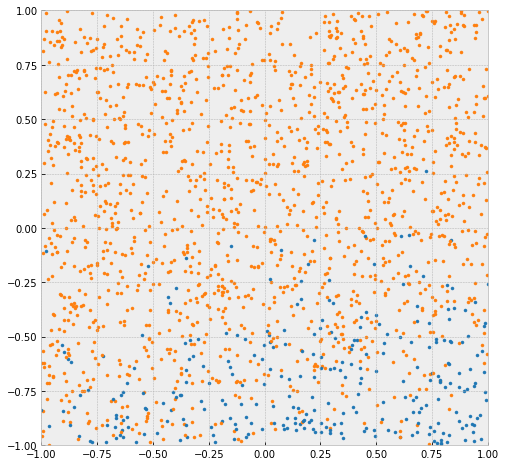

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
colors = sns.color_palette('tab10', n_colors=2)
for i, (x, y) in enumerate(zip(X_train[:300], Y_train[:300])):
    ax.scatter(x[y][:, 0], x[y][:, 1], c=[colors[0]], marker='.')
    ax.scatter(x[~y][:, 0], x[~y][:, 1], c=[colors[1]], marker='.')

In [4]:
from yellowfin import YFOptimizer
from keras.optimizers import TFOptimizer
from keras.metrics import binary_accuracy
opt = TFOptimizer(YFOptimizer(learning_rate=0.1))
fate = FATEChoiceFunction(n_object_features=n_features,
                          n_hidden_joint_layers=2,
                          n_hidden_joint_units=32,
                          n_hidden_set_layers=2,
                          n_hidden_set_units=32,
                          optimizer=opt,
                          batch_size=512,
                          metrics=[binary_accuracy])

In [7]:
fate.fit(X_train, Y_train, verbose=True, epochs=50)

Train on 81000 samples, validate on 9000 samples
Epoch 1/50
81000/81000 [==============================] - 5s 56us/step - loss: 0.0942 - binary_accuracy: 0.9644 - val_loss: 0.0499 - val_binary_accuracy: 0.9767
Epoch 2/50
81000/81000 [==============================] - 3s 41us/step - loss: 0.0429 - binary_accuracy: 0.9824 - val_loss: 0.0438 - val_binary_accuracy: 0.9800
Epoch 3/50
81000/81000 [==============================] - 3s 42us/step - loss: 0.0301 - binary_accuracy: 0.9870 - val_loss: 0.0603 - val_binary_accuracy: 0.9758
Epoch 4/50
81000/81000 [==============================] - 3s 42us/step - loss: 0.0352 - binary_accuracy: 0.9851 - val_loss: 0.0201 - val_binary_accuracy: 0.9913
Epoch 5/50
81000/81000 [==============================] - 3s 42us/step - loss: 0.0293 - binary_accuracy: 0.9880 - val_loss: 0.0107 - val_binary_accuracy: 0.9970
Epoch 6/50
81000/81000 [==============================] - 3s 42us/step - loss: 0.0278 - binary_accuracy: 0.9889 - val_loss: 0.0225 - val_binary_ac

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


KeyboardInterrupt: 

In [8]:
fate.threshold

0.39622626

In [9]:
pred = fate.predict(X_test)

In [10]:
from sklearn.metrics import f1_score, accuracy_score

print('Macro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='macro')))
print('Micro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='micro')))
print('Subset Accuracy: {:.4f}'.format(accuracy_score(Y_test, pred)))

Macro F1 measure: 0.9921
Micro F1 measure: 0.9921
Subset Accuracy: 0.9853


In [11]:
pred_threshold = fate.predict_scores(X_test) > fate.threshold

In [12]:
from sklearn.metrics import f1_score, accuracy_score

print('Macro F1 measure: {:.4f}'.format(f1_score(Y_test, pred_threshold, average='macro')))
print('Micro F1 measure: {:.4f}'.format(f1_score(Y_test, pred_threshold, average='micro')))
print('Subset Accuracy: {:.4f}'.format(accuracy_score(Y_test, pred_threshold)))

Macro F1 measure: 0.9944
Micro F1 measure: 0.9944
Subset Accuracy: 0.9896


## Learning Pareto-Optimality
We now try to solve the problem of predicting the Pareto-optimal set of points $O\subseteq X$.
In other words, it is the set of points which or not dominated by any other point.

Let us plot a small example:

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import numpy as np
from csrank.fate_choice import FATEChoiceFunction

In [13]:
from sklearn.utils import check_random_state
def pareto_front(X, signs=None):
    n_points, n_attributes = X.shape
    if signs is None:
        signs = -np.ones(n_attributes)
    pareto = np.ones(n_points, dtype=bool)
    for i, attr in enumerate(X):
        pareto[i] = np.all(np.any((X*signs[None, :]) <= (attr*signs), axis=1))
    return pareto

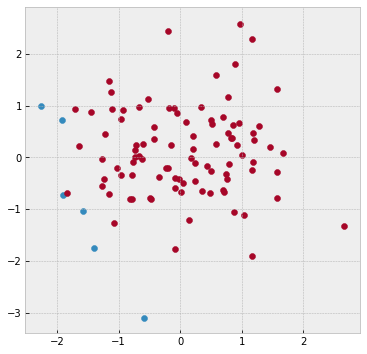

In [14]:
X = np.random.randn(100, 2)
fig, ax = plt.subplots(figsize=(6,6))
pareto = pareto_front(X)
ax.scatter(X[pareto][:, 0], X[pareto][:, 1])
ax.scatter(X[~pareto][:, 0], X[~pareto][:, 1]);

In this example we have to criteria which we want to minimize.
The blue points form the Pareto-front.

In [15]:
from sklearn.utils import check_random_state
def sample_unit_ball(n_inst=10000, n_features=2, rng=None, radius=1.):
    rng = check_random_state(rng)
    X = rng.randn(n_inst, n_features)
    u = rng.uniform(size=n_inst)[:, None]
    X /= np.linalg.norm(X, axis=1, ord=2)[:, None]
    X *= radius * u
    return X
def make_randn_pareto_choices(n_inst=10000, n_features=2, n_objects=10, data_seed=None, center=0.):
    """Generate random objects from a d-dimensional isometric normal distribution.
    
    This should be the easiest possible Pareto-problem, since the model can learn
    a latent-utility which scores how likely a point is on the front (independent
    of the other points)."""
    rand = check_random_state(data_seed)
    X = rand.randn(n_inst, n_objects, n_features)
    Y = np.empty((n_inst, n_objects), dtype=bool)
    for i in range(n_inst):
        Y[i] = pareto_front(X[i])
    return X+center, Y
def make_globular_pareto_choices(n_inst=10000, n_features=2, n_objects=10, data_seed=None,
                                 cluster_spread=1., cluster_size=10):
    rand = check_random_state(data_seed)
    X = np.empty((n_inst, n_objects, n_features))
    Y = np.empty((n_inst, n_objects), dtype=bool)
    for i in range(int(n_inst / cluster_size)):
        center = sample_unit_ball(n_inst=1, n_features=n_features,
                                  rng=rand, radius=cluster_spread)
        x, y = make_randn_pareto_choices(n_inst=cluster_size, n_features=n_features, n_objects=n_objects,
                                         data_seed=rand, center=center)
        X[i*cluster_size:(i+1)*cluster_size] = x
        Y[i*cluster_size:(i+1)*cluster_size] = y
    return X, Y

In [5]:
from csrank import SyntheticIterator
n_inst = 1024
n_objects = 30
n_features = 5
pareto_iter = SyntheticIterator(make_randn_pareto_choices,
                                n_inst=n_inst, n_features=n_features, n_objects=n_objects)

In [16]:
n_train = 10000
n_test = 100000
n_objects = 30
n_features = 2
seed = 123

X_train, Y_train = make_globular_pareto_choices(n_inst=n_train, n_objects=n_objects,
                                             n_features=n_features, data_seed=seed,
                                                cluster_spread=10)
X_test, Y_test = make_globular_pareto_choices(n_inst=n_test, n_objects=n_objects,
                                           n_features=n_features, data_seed=seed+1,
                                              cluster_spread=10)

Text(0.5,1,'Learning the Pareto-front of a given set of points')

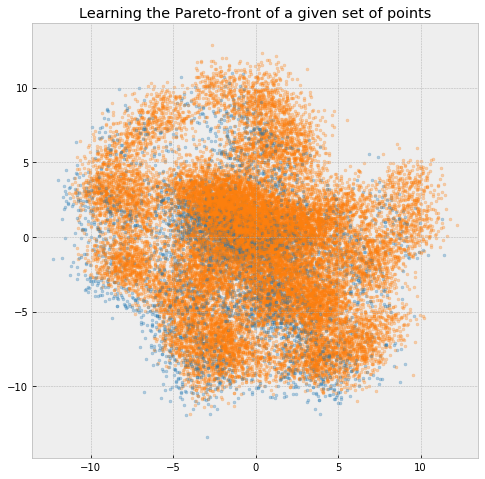

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
#ax.set_xlim(-1, 1)
#ax.set_ylim(-1, 1)
colors = sns.color_palette('tab10', n_colors=2)
for i, (x, y) in enumerate(zip(X_train[:1000], Y_train[:1000])):
    ax.scatter(x[y][:, 0], x[y][:, 1], c=[colors[0]], marker='.', alpha=0.3)
    ax.scatter(x[~y][:, 0], x[~y][:, 1], c=[colors[1]], marker='.', alpha=0.3)
plt.title("Learning the Pareto-front of a given set of points")
#plt.savefig('globular.png')

(-1.5, 1.5)

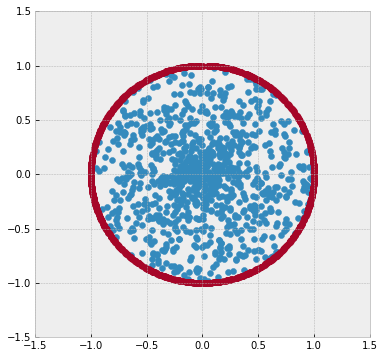

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
n = 1000
a = np.random.randn(n, 2)
u = np.random.uniform(size=n)[:, None]
b = a / np.linalg.norm(a, ord=2, axis=1)[:, None]
c = b * u
#ax.scatter(a[:, 0], a[:, 1])
ax.scatter(c[:, 0], c[:, 1])
ax.scatter(b[:, 0], b[:, 1])

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

In [17]:
import tensorflow as tf
from sklearn.utils import compute_class_weight
from sklearn.metrics import f1_score
def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.

    Here it is only computed as a batch-wise average, not globally.
    """
    return -f1_score(y_true, y_pred, average='samples')

In [10]:
from keras.optimizers import SGD
from keras.metrics import binary_accuracy
from keras.regularizers import l2
from csrank.fate_choice import FATEChoiceFunction
n_hidden_set_units = 128
n_hidden_set_layers = 3
n_hidden_joint_units = 128
n_hidden_joint_layers = 3
fate = FATEChoiceFunction(n_object_features=n_features,
                          n_hidden_joint_layers=n_hidden_joint_layers,
                          n_hidden_joint_units=n_hidden_joint_units,
                          n_hidden_set_layers=n_hidden_set_layers,
                          n_hidden_set_units=n_hidden_set_units,
                          optimizer=SGD(lr=1e-10, momentum=0.9, nesterov=True),
                          #optimizer=opt,
                          batch_size=512,
                          kernel_regularizer=l2(1e-6))

In [11]:
from csrank import ParameterOptimizer
ranges = {fate: {'n_hidden_set_units': (8, 128),
                 'n_hidden_set_layers': (1, 10),
                 'n_hidden_joint_units': (8,  128),
                 'n_hidden_joint_layers': (1, 10),
                 'reg_strength': (1e-10, 1e-2, 'log-uniform'),
                 'learning_rate': (1e-6, 1e-1, 'log-uniform'),
                 'batch_size': (32, 2048)}}
opt=ParameterOptimizer(fate, optimizer_path='runs/id2', tunable_parameter_ranges=ranges,
                   fit_params=dict(epochs=100),
                   random_state=None,
                   validation_loss=fmeasure)

In [12]:
import datetime, time
max_time = datetime.timedelta(hours=24)
max_time = max_time.total_seconds() * 1000 * 1000

In [13]:
import logging
# create logger with 'spam_application'
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('opt.log')
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)

In [ ]:
from sklearn.model_selection import ShuffleSplit

n_iter = 50
eta = np.sqrt(8 * np.log(3)/n_iter)
opt.fit(X_train, Y_train, acq_func="gp_hedge", n_iter=n_iter,
        total_duration=max_time, cv_iter=ShuffleSplit(n_splits=1, test_size=0.1),
        acq_func_kwargs=dict(eta=eta))

In [4]:
from skopt.utils import load
opti = load('./~/optdir')

In [7]:
from skopt.utils import create_result
import numpy as np
#opti = opt.optimizer
result = create_result(opti.Xi, opti.yi, opti.space, opti.rng,
                       models=opti.models)

In [8]:
from skopt.utils import expected_minimum
expected_minimum(result)

([0.031342416687816683, 6.0, 77.0, 67.0, 1.7986618554182078e-09, 410.0, 7.0],
 -0.57176405191421509)

In [18]:
from keras.optimizers import SGD
from keras.metrics import binary_accuracy
from keras.regularizers import l2
from csrank.fate_choice import FATEChoiceFunction
n_hidden_set_units = 77
n_hidden_set_layers = 6
n_hidden_joint_units = 67
n_hidden_joint_layers = 7
fate = FATEChoiceFunction(n_object_features=n_features,
                          n_hidden_joint_layers=n_hidden_joint_layers,
                          n_hidden_joint_units=n_hidden_joint_units,
                          n_hidden_set_layers=n_hidden_set_layers,
                          n_hidden_set_units=n_hidden_set_units,
                          optimizer=SGD(lr=0.031342416687816683, momentum=0.9, nesterov=True),
                          #optimizer=opt,
                          batch_size=410,
                          kernel_regularizer=l2(1.7986618554182078e-09))Pare

In [19]:
fate.fit(X_train, Y_train, epochs=1000, verbose=True)

Train on 8100 samples, validate on 900 samples
Epoch 1/1000
8100/8100 [==============================] - 7s 876us/step - loss: 0.4196 - val_loss: 0.3227
Epoch 2/1000
8100/8100 [==============================] - 2s 268us/step - loss: 0.3122 - val_loss: 0.2440
Epoch 3/1000
8100/8100 [==============================] - 2s 272us/step - loss: 0.3458 - val_loss: 0.3258
Epoch 4/1000
8100/8100 [==============================] - 2s 273us/step - loss: 0.3741 - val_loss: 0.3263
Epoch 5/1000
8100/8100 [==============================] - 2s 273us/step - loss: 0.3677 - val_loss: 0.3307
Epoch 6/1000
8100/8100 [==============================] - 2s 274us/step - loss: 0.2900 - val_loss: 0.2741
Epoch 7/1000
8100/8100 [==============================] - 2s 278us/step - loss: 0.2694 - val_loss: 0.2476
Epoch 8/1000
8100/8100 [==============================] - 2s 278us/step - loss: 0.2442 - val_loss: 0.2137
Epoch 9/1000
8100/8100 [==============================] - 2s 278us/step - loss: 0.2338 - val_loss: 0.2108

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


KeyboardInterrupt: 

In [21]:
fate.threshold

0.27559626

In [20]:
pred = fate.predict(X_test)

In [30]:
pred_scores = fate.predict_scores(X_test)

In [27]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, hamming_loss, zero_one_loss, recall_score, roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import label_ranking_loss
f1 = f1_score(Y_test, pred, average='samples')
prec = precision_score(Y_test, pred, average='samples')
rec = recall_score(Y_test, pred, average='samples')
subsetloss = zero_one_loss(Y_test, pred)
hamming = hamming_loss(Y_test, pred)
auc = roc_auc_score(Y_test, pred_scores, average='samples')
maps = average_precision_score(Y_test, pred_scores, average='samples')
print('F1: {}\nPrecision: {}\nRecall: {}\nSubset 0/1 Loss: {}\nHamming loss: {}\nAUC: {}\nMAP: {}'.format(
    f1, prec, rec, subsetloss, hamming, auc, maps))

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


F1: 0.7038613825068271
Precision: 0.5883390156167355
Subset 0/1 Loss: 0.92271
Hamming loss: 0.084829


In [44]:
average_precision_score(Y_test, pred_scores, average='samples')

0.91310872738555571

In [35]:
from sklearn.metrics import precision_score, roc_auc_score, recall_score
recall_score(Y_test, pred, average='samples')

0.83650843073593062

In [40]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, pred)

0.077289999999999998

In [43]:
from sklearn.metrics import label_ranking_average_precision_score
label_ranking_average_precision_score(Y_test, pred_scores)

0.9131087273854791

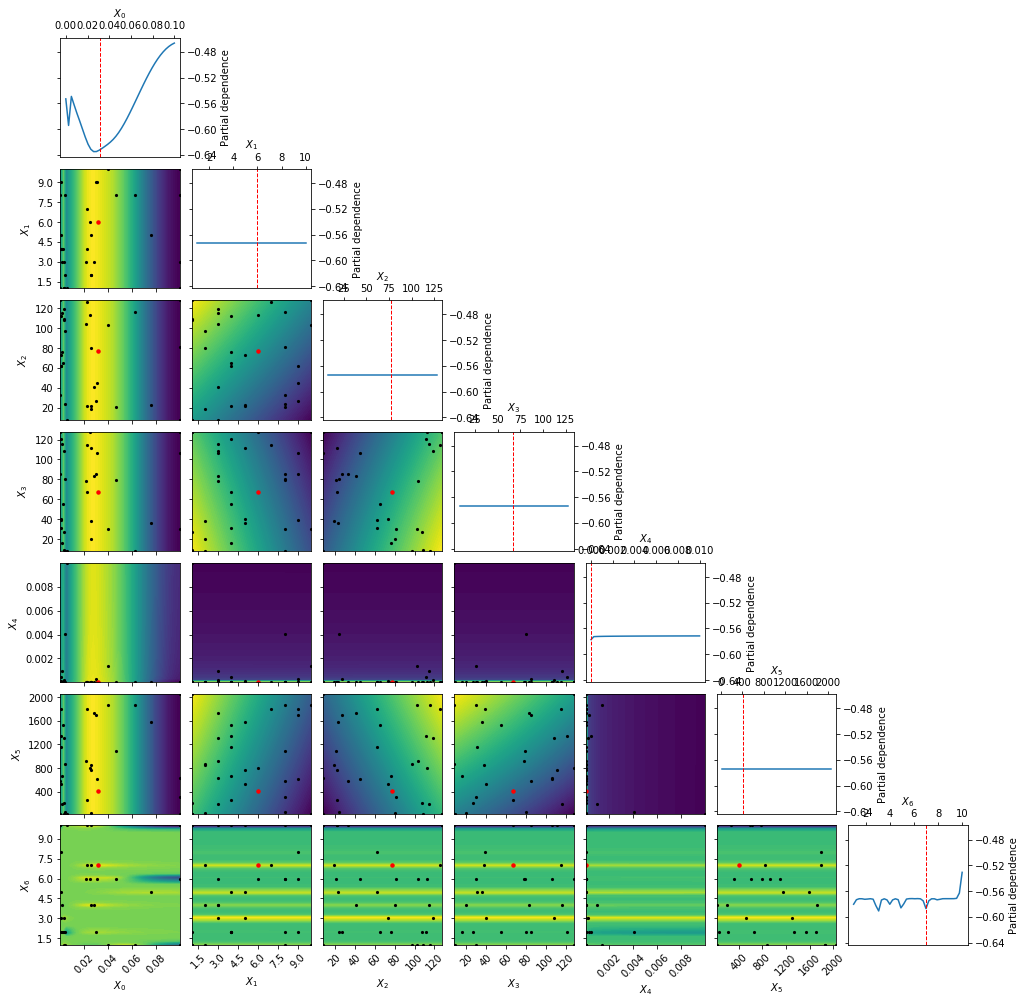

In [10]:
%matplotlib inline
from skopt.plots import plot_objective
plot_objective(result, levels=101);

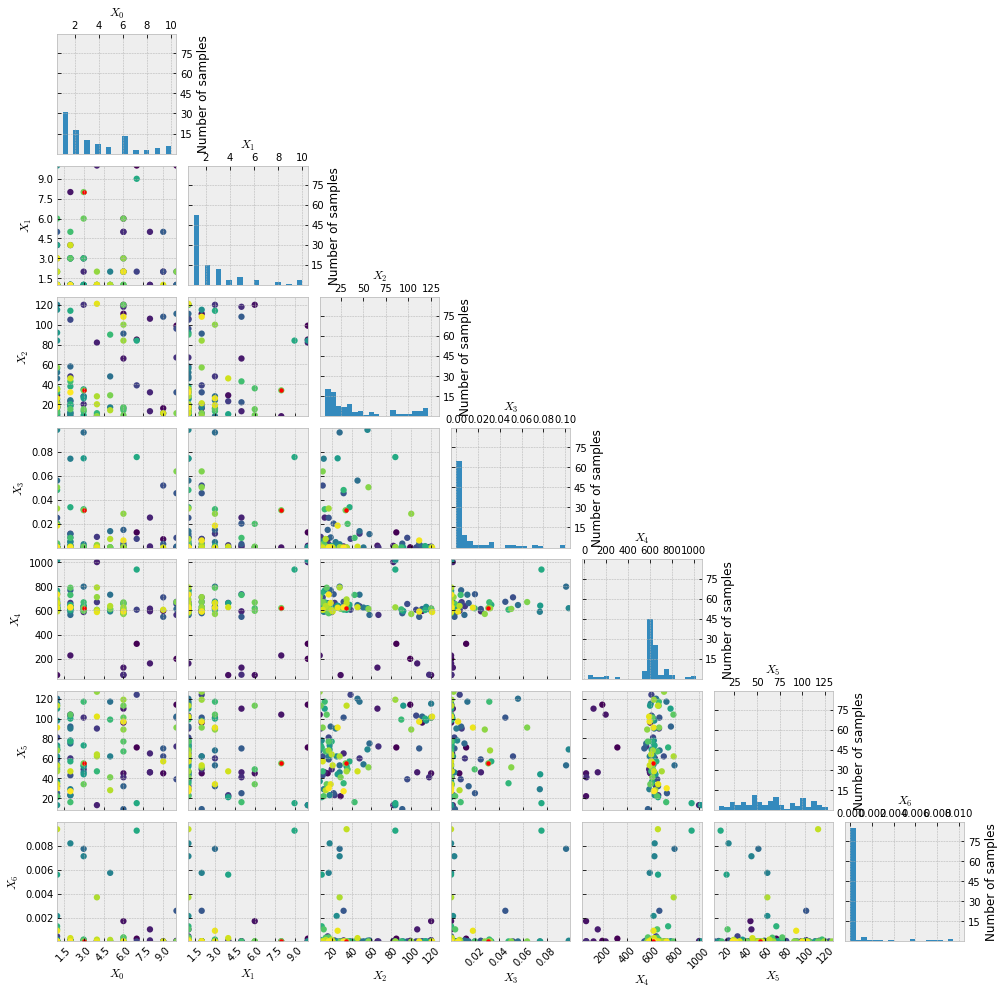

In [19]:
from skopt.plots import plot_evaluations
plot_evaluations(result);

In [60]:
from keras.callbacks import TensorBoard, LearningRateScheduler
netname = '{}-{}-{}-{}-{}d-{}o'.format(n_hidden_set_units, n_hidden_set_layers,
                               n_hidden_joint_units, n_hidden_joint_layers, n_features,
                               n_objects)
tb = TensorBoard(log_dir='/home/kiudee/git/cs-ranking/logs/{}'.format(netname))
tb.__name__ = 'TensorBoard'

def trapezoidal(epoch):
    low_lr = 1e-10
    high_lr = 1e-1
    epochs_ramp_up = 15
    epochs_explore = 60
    epochs_ramp_down = 50
    if epoch <= epochs_ramp_up:
        p = epoch / epochs_ramp_up
        return p * high_lr + (1-p) * low_lr
    elif epoch > epochs_ramp_up and epoch < epochs_explore + epochs_ramp_up:
        return high_lr
    else:
        p = (epoch - epochs_explore - epochs_ramp_up) / epochs_ramp_down
        return min(p * low_lr + (1-p) * high_lr, high_lr)
lr = LearningRateScheduler(trapezoidal)
lr.__name__ = 'LRScheduler'

In [61]:
fate.fit(X_train, Y_train, verbose=False, epochs=140, log_callbacks=[tb, lr])

In [44]:
fate.fit(X_train, Y_train, verbose=False, epochs=10, log_callbacks=[tb],
         optimizer=SGD(lr=1e-6, momentum=0.9, nesterov=True))

In [28]:
X_test, Y_test = make_randn_pareto_choices(n_inst=10000, n_objects=n_objects,
                                           n_features=n_features)

In [127]:
from sklearn.metrics import f1_score, accuracy_score
#X_test, Y_test = make_randn_pareto_choices()
pred = fate.predict(X_test)
print('Macro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='macro')))
print('Micro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='micro')))
print('Subset Accuracy: {:.4f}'.format(accuracy_score(Y_test, pred)))

Macro F1 measure: 0.5703
Micro F1 measure: 0.5705
Subset Accuracy: 0.0938


In [43]:
from sklearn.metrics import f1_score, accuracy_score
#X_test, Y_test = make_randn_pareto_choices()
pred = fate.predict(X_test)
print('Macro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='macro')))
print('Micro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='micro')))
print('Subset Accuracy: {:.4f}'.format(accuracy_score(Y_test, pred)))

Macro F1 measure: 0.0000
Micro F1 measure: 0.0000
Subset Accuracy: 0.0000


/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Learning Largest MNIST Numbers

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import numpy as np
from csrank.fate_choice import FATEChoiceFunction
import tensorflow as tf
from sklearn.utils import compute_class_weight
from sklearn.metrics import f1_score
def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.

    Here it is only computed as a batch-wise average, not globally.
    """
    return -f1_score(y_true, y_pred, average='samples')

Using TensorFlow backend.


In [2]:
X_train = np.load('./largest_mnist_X_train.npy')
X_test = np.load('./largest_mnist_X_test.npy')
Y_train = np.load('./largest_mnist_Y_train.npy')
Y_test = np.load('./largest_mnist_Y_test.npy')
n_instances, n_objects, n_features = X_train.shape

In [3]:
from keras.optimizers import SGD
from keras.metrics import binary_accuracy
from keras.regularizers import l2
from csrank.fate_choice import FATEChoiceFunction
n_hidden_set_units = 128
n_hidden_set_layers = 3
n_hidden_joint_units = 128
n_hidden_joint_layers = 3
epochs = 120
fate = FATEChoiceFunction(n_object_features=n_features,
                          n_hidden_joint_layers=n_hidden_joint_layers,
                          n_hidden_joint_units=n_hidden_joint_units,
                          n_hidden_set_layers=n_hidden_set_layers,
                          n_hidden_set_units=n_hidden_set_units,
                          optimizer=SGD(lr=1e-10, momentum=0.9, nesterov=True),
                          #optimizer=opt,
                          batch_size=512,
                          kernel_regularizer=l2(1e-6))

In [4]:
from csrank.callbacks import LRScheduler
lr = LRScheduler(epochs_drop=epochs // 3, drop=0.1)

In [5]:
from csrank import ParameterOptimizer
ranges = {fate: {'n_hidden_set_units': (8, 128),
                 'n_hidden_set_layers': (1, 10),
                 'n_hidden_joint_units': (8,  128),
                 'n_hidden_joint_layers': (1, 10),
                 'reg_strength': (1e-10, 1e-2, 'log-uniform'),
                 'learning_rate': (1e-3, 1e-1, 'log-uniform'),
                 'batch_size': (200, 1024)},
          lr:   {'drop': (0.01, 0.5, 'uniform')}}
opt=ParameterOptimizer(fate, optimizer_path='runs/id5', tunable_parameter_ranges=ranges,
                   fit_params=dict(epochs=epochs, validation_split=0.0, callbacks=[lr]),
                   random_state=None,
                   validation_loss=fmeasure)

In [6]:
import logging
# create logger with 'spam_application'
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('opt.log')
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)

In [7]:
import tracemalloc
tracemalloc.start()

# ... run your application ...

In [8]:
from sklearn.model_selection import ShuffleSplit
import datetime, time
max_time = datetime.timedelta(hours=24)
max_time = max_time.total_seconds() * 1000 * 1000
n_iter = 100
n_init = 15
eta = np.sqrt(8 * np.log(3)/(n_iter-n_init))
opt.fit(X_train, Y_train, acq_func="gp_hedge", n_iter=n_iter, n_initial_points=n_init,
        total_duration=max_time, cv_iter=ShuffleSplit(n_splits=1, test_size=0.1),
        acq_func_kwargs=dict(eta=eta))

2018-04-11 19:04:28,559 - ParameterOptimizer - DEBUG - Random seed for the ranking algorithm: 1158762303
2018-04-11 19:04:28,560 - ParameterOptimizer - DEBUG - Random seed for the optimizer: 3931908253
2018-04-11 19:04:28,562 - ParameterOptimizer - DEBUG - Random seed for the GP surrogate: 3445558479
2018-04-11 19:04:28,575 - ParameterOptimizer - INFO - Parameter Space: [Real(low=0.001, high=0.1, prior=log-uniform, transform=identity), Integer(low=200, high=1024), Integer(low=1, high=10), Integer(low=1, high=10), Real(low=1e-10, high=0.01, prior=log-uniform, transform=identity), Integer(low=8, high=128), Integer(low=8, high=128), Real(low=0.01, high=0.5, prior=uniform, transform=identity)]
2018-04-11 19:04:28,589 - ParameterOptimizer - INFO - Parameter Space after transformation: Space([Real(low=0.001, high=0.1, prior=log-uniform, transform=normalize),
       Integer(low=200, high=1024),
       Integer(low=1, high=10),
       Integer(low=1, high=10),
       Real(low=1e-10, high=0.01, p

2018-04-11 19:14:59,345 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.6795:
 [0.0015772467575590526, 680, 7, 9, 0.0025244372522949796, 102, 77, 0.10264875409680016]
2018-04-11 19:14:59,469 - ParameterOptimizer - INFO - Next parameters:
[0.0015327749007912762, 309, 5, 6, 0.00287977768859365, 119, 95, 0.4663330544869852]
2018-04-11 19:14:59,521 - ParameterOptimizer - INFO - obj: FATEChoiceFunction, current parameters {'learning_rate': 0.0015327749007912762, 'batch_size': 309, 'n_hidden_set_layers': 5, 'n_hidden_joint_layers': 6, 'reg_strength': 0.00287977768859365, 'n_hidden_set_units': 119, 'n_hidden_joint_units': 95}
2018-04-11 19:14:59,558 - FATEChoiceFunction - INFO - Creating set layers with set units 119 set layer 5 
2018-04-11 19:14:59,561 - ParameterOptimizer - INFO - obj: LRScheduler, current parameters {'drop': 0.4663330544869852}
2018-04-11 19:17:49,309 - ParameterOptimizer - INFO - Validation error for the parameters is -0.7056
2018-04-11 19:17:49,311

2018-04-11 19:25:09,270 - ParameterOptimizer - INFO - obj: FATEChoiceFunction, current parameters {'learning_rate': 0.072126708175403675, 'batch_size': 223, 'n_hidden_set_layers': 6, 'n_hidden_joint_layers': 10, 'reg_strength': 0.00072189086669475176, 'n_hidden_set_units': 27, 'n_hidden_joint_units': 79}
2018-04-11 19:25:09,307 - FATEChoiceFunction - INFO - Creating set layers with set units 27 set layer 6 
2018-04-11 19:25:09,309 - ParameterOptimizer - INFO - obj: LRScheduler, current parameters {'drop': 0.17464975011750433}
2018-04-11 19:29:39,786 - ParameterOptimizer - INFO - Validation error for the parameters is -0.3790
2018-04-11 19:29:39,788 - ParameterOptimizer - INFO - Time taken for the parameters is 0:04:30.515887
2018-04-11 19:29:39,790 - ParameterOptimizer - INFO - current optimizer iteration end 9
2018-04-11 19:29:39,791 - ParameterOptimizer - INFO - Main optimizer iterations done 10 and saving the model
2018-04-11 19:29:39,809 - ParameterOptimizer - INFO - Time left for 

2018-04-11 19:37:40,713 - FATEChoiceFunction - INFO - Creating set layers with set units 119 set layer 5 
2018-04-11 19:37:40,716 - ParameterOptimizer - INFO - obj: LRScheduler, current parameters {'drop': 0.20192433478826632}
2018-04-11 19:39:13,875 - ParameterOptimizer - INFO - Validation error for the parameters is -0.7701
2018-04-11 19:39:13,877 - ParameterOptimizer - INFO - Time taken for the parameters is 0:01:33.196244
2018-04-11 19:39:15,227 - ParameterOptimizer - INFO - current optimizer iteration end 14
2018-04-11 19:39:15,228 - ParameterOptimizer - INFO - Main optimizer iterations done 15 and saving the model
2018-04-11 19:39:15,249 - ParameterOptimizer - INFO - Time left for simulations is 23:25:13.331812 
2018-04-11 19:39:15,250 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 15
2018-04-11 19:39:15,251 - ParameterOptimizer - INFO - Starting optimization iteration: 15
2018-04-11 19:39:15,253 - ParameterOptimizer - INFO -

2018-04-11 19:45:28,367 - ParameterOptimizer - INFO - Validation error for the parameters is 0.0000
2018-04-11 19:45:28,369 - ParameterOptimizer - INFO - Time taken for the parameters is 0:01:30.141997
2018-04-11 19:45:29,701 - ParameterOptimizer - INFO - current optimizer iteration end 18
2018-04-11 19:45:29,702 - ParameterOptimizer - INFO - Main optimizer iterations done 19 and saving the model
2018-04-11 19:45:29,732 - ParameterOptimizer - INFO - Time left for simulations is 23:18:58.853496 
2018-04-11 19:45:29,733 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 19
2018-04-11 19:45:29,734 - ParameterOptimizer - INFO - Starting optimization iteration: 19
2018-04-11 19:45:29,735 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7818:
 [0.041182813584963743, 1024, 7, 3, 1.6263688601262661e-08, 82, 101, 0.47020303122252355]
2018-04-11 19:45:29,916 - ParameterOptimizer - INFO - Next parameters:
[0.001, 1024, 10, 1

2018-04-11 19:54:30,521 - ParameterOptimizer - INFO - Validation error for the parameters is -0.5899
2018-04-11 19:54:30,523 - ParameterOptimizer - INFO - Time taken for the parameters is 0:02:54.789552
2018-04-11 19:54:31,994 - ParameterOptimizer - INFO - current optimizer iteration end 22
2018-04-11 19:54:31,995 - ParameterOptimizer - INFO - Main optimizer iterations done 23 and saving the model
2018-04-11 19:54:32,036 - ParameterOptimizer - INFO - Time left for simulations is 23:09:56.554963 
2018-04-11 19:54:32,037 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 23
2018-04-11 19:54:32,038 - ParameterOptimizer - INFO - Starting optimization iteration: 23
2018-04-11 19:54:32,040 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7818:
 [0.041182813584963743, 1024, 7, 3, 1.6263688601262661e-08, 82, 101, 0.47020303122252355]
2018-04-11 19:54:32,120 - ParameterOptimizer - INFO - Next parameters:
[0.012810975468494

2018-04-11 20:01:51,415 - ParameterOptimizer - INFO - Validation error for the parameters is -0.7360
2018-04-11 20:01:51,417 - ParameterOptimizer - INFO - Time taken for the parameters is 0:01:29.605306
2018-04-11 20:01:53,134 - ParameterOptimizer - INFO - current optimizer iteration end 26
2018-04-11 20:01:53,135 - ParameterOptimizer - INFO - Main optimizer iterations done 27 and saving the model
2018-04-11 20:01:53,192 - ParameterOptimizer - INFO - Time left for simulations is 23:02:35.403440 
2018-04-11 20:01:53,194 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 27
2018-04-11 20:01:53,196 - ParameterOptimizer - INFO - Starting optimization iteration: 27
2018-04-11 20:01:53,197 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7818:
 [0.041182813584963743, 1024, 7, 3, 1.6263688601262661e-08, 82, 101, 0.47020303122252355]
2018-04-11 20:01:53,301 - ParameterOptimizer - INFO - Next parameters:
[0.001, 298, 1, 10

2018-04-11 20:12:08,451 - ParameterOptimizer - INFO - Validation error for the parameters is -0.7590
2018-04-11 20:12:08,453 - ParameterOptimizer - INFO - Time taken for the parameters is 0:01:02.877045
2018-04-11 20:12:09,963 - ParameterOptimizer - INFO - current optimizer iteration end 30
2018-04-11 20:12:09,964 - ParameterOptimizer - INFO - Main optimizer iterations done 31 and saving the model
2018-04-11 20:12:10,028 - ParameterOptimizer - INFO - Time left for simulations is 22:52:18.573970 
2018-04-11 20:12:10,029 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 31
2018-04-11 20:12:10,031 - ParameterOptimizer - INFO - Starting optimization iteration: 31
2018-04-11 20:12:10,032 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7818:
 [0.041182813584963743, 1024, 7, 3, 1.6263688601262661e-08, 82, 101, 0.47020303122252355]
2018-04-11 20:12:10,091 - ParameterOptimizer - INFO - Next parameters:
[0.047113145964395

2018-04-11 20:20:17,410 - ParameterOptimizer - INFO - Validation error for the parameters is 0.0000
2018-04-11 20:20:17,412 - ParameterOptimizer - INFO - Time taken for the parameters is 0:04:03.967721
2018-04-11 20:20:19,337 - ParameterOptimizer - INFO - current optimizer iteration end 34
2018-04-11 20:20:19,338 - ParameterOptimizer - INFO - Main optimizer iterations done 35 and saving the model
2018-04-11 20:20:19,414 - ParameterOptimizer - INFO - Time left for simulations is 22:44:09.193481 
2018-04-11 20:20:19,415 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 35
2018-04-11 20:20:19,416 - ParameterOptimizer - INFO - Starting optimization iteration: 35
2018-04-11 20:20:19,417 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7946:
 [0.047113145964395697, 1024, 6, 4, 4.9755581569206406e-08, 89, 74, 0.5]
2018-04-11 20:20:19,508 - ParameterOptimizer - INFO - Next parameters:
[0.015990182231760568, 1024, 5, 10, 

2018-04-11 20:26:26,709 - ParameterOptimizer - INFO - Validation error for the parameters is -0.7744
2018-04-11 20:26:26,711 - ParameterOptimizer - INFO - Time taken for the parameters is 0:01:04.330990
2018-04-11 20:26:28,647 - ParameterOptimizer - INFO - current optimizer iteration end 38
2018-04-11 20:26:28,649 - ParameterOptimizer - INFO - Main optimizer iterations done 39 and saving the model
2018-04-11 20:26:28,737 - ParameterOptimizer - INFO - Time left for simulations is 22:37:59.875116 
2018-04-11 20:26:28,739 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 39
2018-04-11 20:26:28,741 - ParameterOptimizer - INFO - Starting optimization iteration: 39
2018-04-11 20:26:28,743 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7946:
 [0.047113145964395697, 1024, 6, 4, 4.9755581569206406e-08, 89, 74, 0.5]
2018-04-11 20:26:28,800 - ParameterOptimizer - INFO - Next parameters:
[0.010950760605501198, 200, 10, 3, 

2018-04-11 20:36:58,836 - ParameterOptimizer - INFO - Validation error for the parameters is -0.7899
2018-04-11 20:36:58,838 - ParameterOptimizer - INFO - Time taken for the parameters is 0:01:31.814701
2018-04-11 20:37:01,208 - ParameterOptimizer - INFO - current optimizer iteration end 42
2018-04-11 20:37:01,210 - ParameterOptimizer - INFO - Main optimizer iterations done 43 and saving the model
2018-04-11 20:37:01,308 - ParameterOptimizer - INFO - Time left for simulations is 22:27:27.311047 
2018-04-11 20:37:01,309 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 43
2018-04-11 20:37:01,311 - ParameterOptimizer - INFO - Starting optimization iteration: 43
2018-04-11 20:37:01,313 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7946:
 [0.047113145964395697, 1024, 6, 4, 4.9755581569206406e-08, 89, 74, 0.5]
2018-04-11 20:37:01,428 - ParameterOptimizer - INFO - Next parameters:
[0.09235240496065672, 1024, 10, 6, 

2018-04-11 20:44:58,593 - ParameterOptimizer - INFO - Time taken for the parameters is 0:03:33.582903
2018-04-11 20:45:00,762 - ParameterOptimizer - INFO - current optimizer iteration end 46
2018-04-11 20:45:00,764 - ParameterOptimizer - INFO - Main optimizer iterations done 47 and saving the model
2018-04-11 20:45:00,874 - ParameterOptimizer - INFO - Time left for simulations is 22:19:27.750512 
2018-04-11 20:45:00,875 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 47
2018-04-11 20:45:00,877 - ParameterOptimizer - INFO - Starting optimization iteration: 47
2018-04-11 20:45:00,878 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7946:
 [0.047113145964395697, 1024, 6, 4, 4.9755581569206406e-08, 89, 74, 0.5]
2018-04-11 20:45:00,956 - ParameterOptimizer - INFO - Next parameters:
[0.0014659388472716447, 217, 1, 3, 1e-10, 128, 23, 0.01]
2018-04-11 20:45:01,009 - ParameterOptimizer - INFO - obj: FATEChoiceFunction, 

2018-04-11 20:55:07,724 - ParameterOptimizer - INFO - current optimizer iteration end 50
2018-04-11 20:55:07,725 - ParameterOptimizer - INFO - Main optimizer iterations done 51 and saving the model
2018-04-11 20:55:07,849 - ParameterOptimizer - INFO - Time left for simulations is 22:09:20.781870 
2018-04-11 20:55:07,850 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 51
2018-04-11 20:55:07,852 - ParameterOptimizer - INFO - Starting optimization iteration: 51
2018-04-11 20:55:07,853 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7966:
 [0.033036642817965936, 371, 8, 10, 1.1433716463695887e-09, 64, 88, 0.49716623935906618]
2018-04-11 20:55:07,925 - ParameterOptimizer - INFO - Next parameters:
[0.070377632730082476, 449, 1, 8, 0.00019106123447166457, 31, 14, 0.5]
2018-04-11 20:55:07,981 - ParameterOptimizer - INFO - obj: FATEChoiceFunction, current parameters {'learning_rate': 0.070377632730082476, 'batch_size':

2018-04-11 21:03:55,387 - ParameterOptimizer - INFO - current optimizer iteration end 54
2018-04-11 21:03:55,388 - ParameterOptimizer - INFO - Main optimizer iterations done 55 and saving the model
2018-04-11 21:03:55,518 - ParameterOptimizer - INFO - Time left for simulations is 22:00:33.117683 
2018-04-11 21:03:55,520 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 55
2018-04-11 21:03:55,521 - ParameterOptimizer - INFO - Starting optimization iteration: 55
2018-04-11 21:03:55,522 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7966:
 [0.033036642817965936, 371, 8, 10, 1.1433716463695887e-09, 64, 88, 0.49716623935906618]
2018-04-11 21:03:55,596 - ParameterOptimizer - INFO - Next parameters:
[0.017222018759389026, 200, 1, 4, 3.2141681426073772e-10, 77, 80, 0.34177050158223998]
2018-04-11 21:03:55,645 - ParameterOptimizer - INFO - obj: FATEChoiceFunction, current parameters {'learning_rate': 0.01722201875938902

2018-04-11 21:17:29,295 - ParameterOptimizer - INFO - Time taken for the parameters is 0:04:28.719091
2018-04-11 21:17:31,713 - ParameterOptimizer - INFO - current optimizer iteration end 58
2018-04-11 21:17:31,714 - ParameterOptimizer - INFO - Main optimizer iterations done 59 and saving the model
2018-04-11 21:17:31,864 - ParameterOptimizer - INFO - Time left for simulations is 21:46:56.778063 
2018-04-11 21:17:31,865 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 59
2018-04-11 21:17:31,866 - ParameterOptimizer - INFO - Starting optimization iteration: 59
2018-04-11 21:17:31,868 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7966:
 [0.033036642817965936, 371, 8, 10, 1.1433716463695887e-09, 64, 88, 0.49716623935906618]
2018-04-11 21:17:31,959 - ParameterOptimizer - INFO - Next parameters:
[0.061054945124137235, 1024, 4, 6, 2.1919621375617209e-09, 19, 107, 0.5]
2018-04-11 21:17:32,014 - ParameterOptimizer - 

2018-04-11 21:26:42,789 - ParameterOptimizer - INFO - Time taken for the parameters is 0:01:06.615120
2018-04-11 21:26:45,027 - ParameterOptimizer - INFO - current optimizer iteration end 62
2018-04-11 21:26:45,029 - ParameterOptimizer - INFO - Main optimizer iterations done 63 and saving the model
2018-04-11 21:26:45,186 - ParameterOptimizer - INFO - Time left for simulations is 21:37:43.462502 
2018-04-11 21:26:45,188 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 63
2018-04-11 21:26:45,189 - ParameterOptimizer - INFO - Starting optimization iteration: 63
2018-04-11 21:26:45,191 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7966:
 [0.033036642817965936, 371, 8, 10, 1.1433716463695887e-09, 64, 88, 0.49716623935906618]
2018-04-11 21:26:45,257 - ParameterOptimizer - INFO - Next parameters:
[0.053737398465804033, 200, 5, 10, 4.2567826406534853e-05, 128, 72, 0.4339544958506471]
2018-04-11 21:26:45,311 - Parame

2018-04-11 21:42:17,057 - ParameterOptimizer - INFO - Validation error for the parameters is -0.7622
2018-04-11 21:42:17,058 - ParameterOptimizer - INFO - Time taken for the parameters is 0:04:14.856473
2018-04-11 21:42:19,255 - ParameterOptimizer - INFO - current optimizer iteration end 66
2018-04-11 21:42:19,256 - ParameterOptimizer - INFO - Main optimizer iterations done 67 and saving the model
2018-04-11 21:42:19,422 - ParameterOptimizer - INFO - Time left for simulations is 21:22:09.233803 
2018-04-11 21:42:19,423 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 67
2018-04-11 21:42:19,425 - ParameterOptimizer - INFO - Starting optimization iteration: 67
2018-04-11 21:42:19,426 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7966:
 [0.033036642817965936, 371, 8, 10, 1.1433716463695887e-09, 64, 88, 0.49716623935906618]
2018-04-11 21:42:19,527 - ParameterOptimizer - INFO - Next parameters:
[0.0231556746038954

2018-04-11 21:57:57,502 - ParameterOptimizer - INFO - Validation error for the parameters is -0.7696
2018-04-11 21:57:57,504 - ParameterOptimizer - INFO - Time taken for the parameters is 0:03:56.962320
2018-04-11 21:57:59,658 - ParameterOptimizer - INFO - current optimizer iteration end 70
2018-04-11 21:57:59,660 - ParameterOptimizer - INFO - Main optimizer iterations done 71 and saving the model
2018-04-11 21:57:59,837 - ParameterOptimizer - INFO - Time left for simulations is 21:06:28.824534 
2018-04-11 21:57:59,839 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 71
2018-04-11 21:57:59,840 - ParameterOptimizer - INFO - Starting optimization iteration: 71
2018-04-11 21:57:59,841 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7966:
 [0.033036642817965936, 371, 8, 10, 1.1433716463695887e-09, 64, 88, 0.49716623935906618]
2018-04-11 21:57:59,939 - ParameterOptimizer - INFO - Next parameters:
[0.0339633930934780

2018-04-11 22:12:52,076 - ParameterOptimizer - INFO - Validation error for the parameters is -0.6695
2018-04-11 22:12:52,078 - ParameterOptimizer - INFO - Time taken for the parameters is 0:01:30.848921
2018-04-11 22:12:54,123 - ParameterOptimizer - INFO - current optimizer iteration end 74
2018-04-11 22:12:54,125 - ParameterOptimizer - INFO - Main optimizer iterations done 75 and saving the model
2018-04-11 22:12:54,314 - ParameterOptimizer - INFO - Time left for simulations is 20:51:34.353955 
2018-04-11 22:12:54,316 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 75
2018-04-11 22:12:54,317 - ParameterOptimizer - INFO - Starting optimization iteration: 75
2018-04-11 22:12:54,319 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7966:
 [0.033036642817965936, 371, 8, 10, 1.1433716463695887e-09, 64, 88, 0.49716623935906618]
2018-04-11 22:12:54,357 - ParameterOptimizer - INFO - Next parameters:
[0.0171973778477998

2018-04-11 22:23:28,193 - ParameterOptimizer - INFO - Validation error for the parameters is -0.7318
2018-04-11 22:23:28,195 - ParameterOptimizer - INFO - Time taken for the parameters is 0:01:16.049191
2018-04-11 22:23:30,596 - ParameterOptimizer - INFO - current optimizer iteration end 78
2018-04-11 22:23:30,597 - ParameterOptimizer - INFO - Main optimizer iterations done 79 and saving the model
2018-04-11 22:23:30,797 - ParameterOptimizer - INFO - Time left for simulations is 20:40:57.878407 
2018-04-11 22:23:30,798 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 79
2018-04-11 22:23:30,800 - ParameterOptimizer - INFO - Starting optimization iteration: 79
2018-04-11 22:23:30,801 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7966:
 [0.033036642817965936, 371, 8, 10, 1.1433716463695887e-09, 64, 88, 0.49716623935906618]
2018-04-11 22:23:30,858 - ParameterOptimizer - INFO - Next parameters:
[0.0307125884522558

2018-04-11 22:32:28,892 - ParameterOptimizer - INFO - Validation error for the parameters is -0.6968
2018-04-11 22:32:28,893 - ParameterOptimizer - INFO - Time taken for the parameters is 0:01:13.249578
2018-04-11 22:32:31,194 - ParameterOptimizer - INFO - current optimizer iteration end 82
2018-04-11 22:32:31,195 - ParameterOptimizer - INFO - Main optimizer iterations done 83 and saving the model
2018-04-11 22:32:31,409 - ParameterOptimizer - INFO - Time left for simulations is 20:31:57.272554 
2018-04-11 22:32:31,410 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 83
2018-04-11 22:32:31,411 - ParameterOptimizer - INFO - Starting optimization iteration: 83
2018-04-11 22:32:31,413 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7966:
 [0.033036642817965936, 371, 8, 10, 1.1433716463695887e-09, 64, 88, 0.49716623935906618]
2018-04-11 22:32:31,503 - ParameterOptimizer - INFO - Next parameters:
[0.0425986337075478

2018-04-11 22:43:10,198 - ParameterOptimizer - INFO - Time taken for the parameters is 0:03:18.294463
2018-04-11 22:43:12,546 - ParameterOptimizer - INFO - current optimizer iteration end 86
2018-04-11 22:43:12,548 - ParameterOptimizer - INFO - Main optimizer iterations done 87 and saving the model
2018-04-11 22:43:12,779 - ParameterOptimizer - INFO - Time left for simulations is 20:21:15.908363 
2018-04-11 22:43:12,781 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 87
2018-04-11 22:43:12,783 - ParameterOptimizer - INFO - Starting optimization iteration: 87
2018-04-11 22:43:12,784 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7966:
 [0.033036642817965936, 371, 8, 10, 1.1433716463695887e-09, 64, 88, 0.49716623935906618]
2018-04-11 22:43:12,851 - ParameterOptimizer - INFO - Next parameters:
[0.0097916103183172901, 240, 10, 10, 0.01, 128, 8, 0.5]
2018-04-11 22:43:12,904 - ParameterOptimizer - INFO - obj: FATEC

2018-04-11 22:57:52,475 - ParameterOptimizer - INFO - current optimizer iteration end 90
2018-04-11 22:57:52,477 - ParameterOptimizer - INFO - Main optimizer iterations done 91 and saving the model
2018-04-11 22:57:52,713 - ParameterOptimizer - INFO - Time left for simulations is 20:06:35.981798 
2018-04-11 22:57:52,715 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 91
2018-04-11 22:57:52,717 - ParameterOptimizer - INFO - Starting optimization iteration: 91
2018-04-11 22:57:52,719 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7966:
 [0.033036642817965936, 371, 8, 10, 1.1433716463695887e-09, 64, 88, 0.49716623935906618]
2018-04-11 22:57:52,855 - ParameterOptimizer - INFO - Next parameters:
[0.025365804030133235, 454, 8, 10, 4.4039796645020662e-07, 48, 16, 0.5]
2018-04-11 22:57:52,907 - ParameterOptimizer - INFO - obj: FATEChoiceFunction, current parameters {'learning_rate': 0.025365804030133235, 'batch_size'

2018-04-11 23:05:50,215 - ParameterOptimizer - INFO - Time taken for the parameters is 0:01:49.120174
2018-04-11 23:05:53,085 - ParameterOptimizer - INFO - current optimizer iteration end 94
2018-04-11 23:05:53,086 - ParameterOptimizer - INFO - Main optimizer iterations done 95 and saving the model
2018-04-11 23:05:53,335 - ParameterOptimizer - INFO - Time left for simulations is 19:58:35.366776 
2018-04-11 23:05:53,337 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 95
2018-04-11 23:05:53,339 - ParameterOptimizer - INFO - Starting optimization iteration: 95
2018-04-11 23:05:53,341 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7966:
 [0.033036642817965936, 371, 8, 10, 1.1433716463695887e-09, 64, 88, 0.49716623935906618]
2018-04-11 23:05:53,476 - ParameterOptimizer - INFO - Next parameters:
[0.040177267472579596, 1024, 1, 10, 1e-10, 128, 8, 0.5]
2018-04-11 23:05:53,530 - ParameterOptimizer - INFO - obj: FATEC

2018-04-11 23:15:23,328 - ParameterOptimizer - INFO - current optimizer iteration end 98
2018-04-11 23:15:23,329 - ParameterOptimizer - INFO - Main optimizer iterations done 99 and saving the model
2018-04-11 23:15:23,589 - ParameterOptimizer - INFO - Time left for simulations is 19:49:05.119992 
2018-04-11 23:15:23,591 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 99
2018-04-11 23:15:23,592 - ParameterOptimizer - INFO - Starting optimization iteration: 99
2018-04-11 23:15:23,593 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7966:
 [0.033036642817965936, 371, 8, 10, 1.1433716463695887e-09, 64, 88, 0.49716623935906618]
2018-04-11 23:15:23,706 - ParameterOptimizer - INFO - Next parameters:
[0.02589507902620931, 1015, 9, 4, 1e-10, 128, 123, 0.472650308751764]
2018-04-11 23:15:23,761 - ParameterOptimizer - INFO - obj: FATEChoiceFunction, current parameters {'learning_rate': 0.02589507902620931, 'batch_size': 1

In [9]:
from skopt.utils import create_result
import numpy as np
opti = opt.optimizer
result = create_result(opti.Xi, opti.yi, opti.space, opti.rng,
                       models=opti.models)

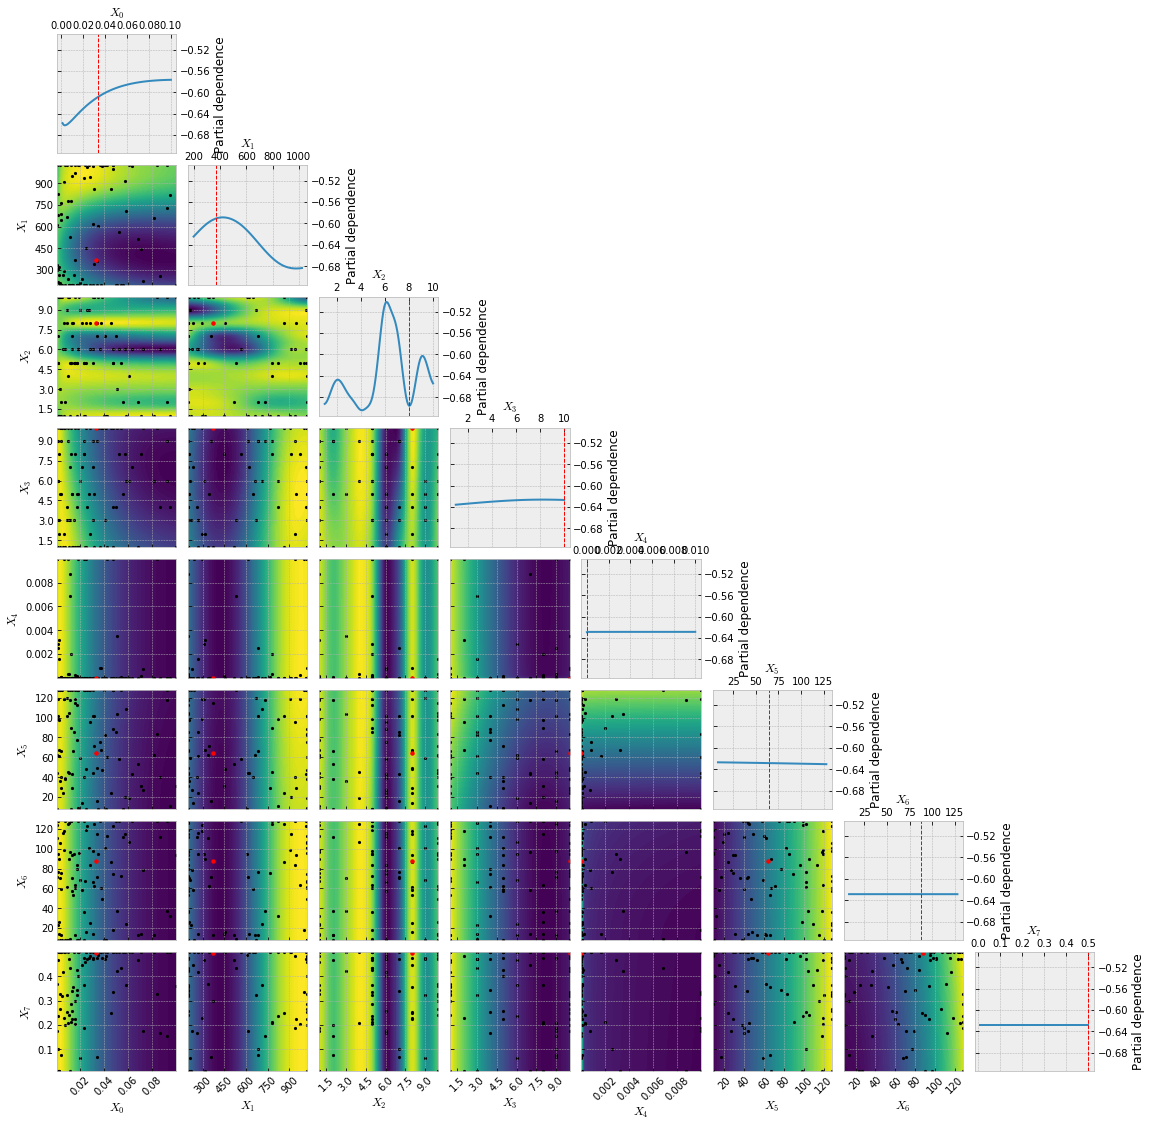

In [18]:
%matplotlib inline
from skopt.plots import plot_objective
plot_objective(result, levels=101, n_points=101);

In [19]:
plt.savefig('fate_mnist_loss.pdf')

In [11]:
opt.optimizer.Xi[np.argmin(opt.optimizer.yi)]

[0.033036642817965936,
 371,
 8,
 10,
 1.1433716463695887e-09,
 64,
 88,
 0.49716623935906618]

In [12]:
from skopt.utils import expected_minimum
expected_minimum(result)

([0.033036642817965936,
  371.0,
  8.0,
  10.0,
  1.1433716463695887e-09,
  64.0,
  88.0,
  0.49716623935906618],
 -0.65608245134353638)

In [ ]:
{'n_hidden_set_units': 99, 'batch_size': 128, 'reg_strength': 1e-10, 'n_hidden_set_layers': 7, 'learning_rate': 0.028249056353850843, 'n_hidden_joint_layers': 3, 'n_hidden_joint_units': 128}

In [31]:
from keras.optimizers import SGD
from keras.metrics import binary_accuracy
from keras.regularizers import l2
from csrank.fate_choice import FATEChoiceFunction
n_hidden_set_units = 99
n_hidden_set_layers = 7
n_hidden_joint_units = 128
n_hidden_joint_layers = 3
fate = FATEChoiceFunction(n_object_features=n_features,
                          n_hidden_joint_layers=n_hidden_joint_layers,
                          n_hidden_joint_units=n_hidden_joint_units,
                          n_hidden_set_layers=n_hidden_set_layers,
                          n_hidden_set_units=n_hidden_set_units,
                          optimizer=SGD(lr=0.028249056353850843, momentum=0.9, nesterov=True),
                          #optimizer=opt,
                          batch_size=128,
                          kernel_regularizer=l2(1e-10))

2018-04-11 17:11:34,851 - FATERankingCore - INFO - Construct joint layers hidden units 128 and layers 3 
2018-04-11 17:11:34,853 - FATERankingCore - INFO - Construct output score node
2018-04-11 17:11:34,854 - FATEObjectRankingCore - INFO - args: {'batch_size': 128, 'optimizer': <keras.optimizers.SGD object at 0x7fcc1c11d940>, 'metrics': None, 'kernel_regularizer': <keras.regularizers.L1L2 object at 0x7fcc1c11db70>, 'n_hidden_joint_units': 128, 'n_hidden_joint_layers': 3}
2018-04-11 17:11:34,855 - FATEChoiceFunction - INFO - Creating set layers with set units 99 set layer 7 


In [32]:
from csrank.callbacks import LRScheduler
lr = LRScheduler(epochs_drop=epochs // 3, drop=0.1)

In [ ]:
fate.fit(X_train, Y_train, verbose=True, epochs=120, callbacks=[lr])

Train on 8100 samples, validate on 900 samples
Epoch 1/120


In [13]:
fate = opt.model

In [14]:
pred = fate.predict(X_test)
pred_scores = fate.predict_scores(X_test)

In [15]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, hamming_loss, zero_one_loss, recall_score, roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import label_ranking_loss
f1 = f1_score(Y_test, pred, average='samples')
prec = precision_score(Y_test, pred, average='samples')
rec = recall_score(Y_test, pred, average='samples')
subsetloss = zero_one_loss(Y_test, pred)
hamming = hamming_loss(Y_test, pred)
#auc = roc_auc_score(Y_test, pred_scores, average='samples')
auc = '-'
maps = average_precision_score(Y_test, pred_scores, average='samples')
print('F1: {}\nPrecision: {}\nRecall: {}\nSubset 0/1 Loss: {}\nHamming loss: {}\nAUC: {}\nMAP: {}'.format(
    f1, prec, rec, subsetloss, hamming, auc, maps))

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/home

F1: 0.7913881336310749
Precision: 0.7778235714285715
Recall: 0.8294707142857144
Subset 0/1 Loss: 0.30200000000000005
Hamming loss: 0.05528
AUC: -
MAP: nan


In [16]:
def instance_informedness(y_true, y_pred):
    tp = np.logical_and(y_true, y_pred).sum(axis=1)
    tn = np.logical_and(np.logical_not(y_true), np.logical_not(y_pred)).sum(axis=1)
    cp = y_true.sum(axis=1)
    cn = np.logical_not(y_true).sum(axis=1)
    return np.nanmean(tp/cp + tn/cn - 1)

In [17]:
instance_informedness(Y_test, pred)

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


0.94913124113565528

## FETA

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import numpy as np
from csrank.feta_choice import FETAChoiceFunction
import tensorflow as tf
from sklearn.utils import compute_class_weight
from sklearn.metrics import f1_score
def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.

    Here it is only computed as a batch-wise average, not globally.
    """
    return -f1_score(y_true, y_pred, average='samples')

Using TensorFlow backend.


In [2]:
X_train = np.load('./largest_mnist_X_train.npy')
X_test = np.load('./largest_mnist_X_test.npy')
Y_train = np.load('./largest_mnist_Y_train.npy')
Y_test = np.load('./largest_mnist_Y_test.npy')
n_instances, n_objects, n_features = X_train.shape

In [3]:
from keras.optimizers import SGD
from keras.metrics import binary_accuracy
from keras.regularizers import l2
from csrank.feta_choice import FETAChoiceFunction
epochs = 100
feta = FETAChoiceFunction(
    n_objects=n_objects,
    n_features=n_features,
    n_hidden=5,
    n_units=128,
    max_number_of_objects=10,
    add_zeroth_order_model=True,
    optimizer=SGD(lr=1e-4, momentum=0.9, nesterov=True),
    batch_size=600,
    kernel_regularizer=l2(1e-10),
    #loss_function='mse',
    kernel_initializer="lecun_normal",
    metrics=[binary_accuracy]
)

In [4]:
from csrank.callbacks import LRScheduler
lr = LRScheduler(epochs_drop=epochs // 3, drop=0.1)

In [ ]:
feta.fit(X_train, Y_train, epochs=100, verbose=True)

In [6]:
from csrank import ParameterOptimizer
ranges = {feta: {'n_units': (8, 128),
                 'n_hidden': (1, 20),
                 'reg_strength': (1e-10, 1e-2, 'log-uniform'),
                 'learning_rate': (1e-3, 1e-1, 'log-uniform'),
                 'batch_size': (512, 1024)},
          lr:   {'drop': (0.01, 0.5, 'uniform')}}
opt=ParameterOptimizer(feta, optimizer_path='runs/feta8', tunable_parameter_ranges=ranges,
                   fit_params=dict(epochs=epochs, validation_split=0.0, callbacks=[lr]),
                   random_state=None,
                   validation_loss=fmeasure)

In [7]:
import logging
# create logger with 'spam_application'
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('feta8.log')
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)

In [8]:
import tracemalloc
tracemalloc.start()

# ... run your application ...

In [9]:
from sklearn.model_selection import ShuffleSplit
import datetime, time
max_time = datetime.timedelta(hours=3)
max_time = max_time.total_seconds() * 1000 * 1000
n_iter = 50
n_init = 7
eta = np.sqrt(8 * np.log(3)/(n_iter-n_init))
opt.fit(X_train, Y_train, acq_func="gp_hedge", n_iter=n_iter, n_initial_points=n_init,
        total_duration=max_time, cv_iter=ShuffleSplit(n_splits=1, test_size=0.1),
        acq_func_kwargs=dict(eta=eta))

2018-04-12 18:20:15,664 - ParameterOptimizer - DEBUG - Random seed for the ranking algorithm: 171051625
2018-04-12 18:20:15,665 - ParameterOptimizer - DEBUG - Random seed for the optimizer: 510483167
2018-04-12 18:20:15,666 - ParameterOptimizer - DEBUG - Random seed for the GP surrogate: 1497815460
2018-04-12 18:20:15,676 - ParameterOptimizer - INFO - Parameter Space: [Real(low=1e-10, high=0.01, prior=log-uniform, transform=identity), Integer(low=8, high=128), Real(low=0.001, high=0.1, prior=log-uniform, transform=identity), Integer(low=1, high=20), Integer(low=512, high=1024), Real(low=0.01, high=0.5, prior=uniform, transform=identity)]
2018-04-12 18:20:15,687 - ParameterOptimizer - INFO - Parameter Space after transformation: Space([Real(low=1e-10, high=0.01, prior=log-uniform, transform=normalize),
       Integer(low=8, high=128),
       Real(low=0.001, high=0.1, prior=log-uniform, transform=normalize),
       Integer(low=1, high=20),
       Integer(low=512, high=1024),
       Real(

2018-04-12 18:37:26,530 - FETANetwork - INFO - Tuned threshold, obtained 0.57 which achieved a micro F1-measure of 0.89
2018-04-12 18:37:26,537 - FETANetwork - INFO - Predicting scores
2018-04-12 18:37:26,542 - FETANetwork - INFO - For Test instances 1000 objects 10 features 128
2018-04-12 18:37:30,836 - FETANetwork - INFO - Done predicting scores
2018-04-12 18:37:32,159 - ParameterOptimizer - INFO - Validation error for the parameters is -0.8834
2018-04-12 18:37:32,160 - ParameterOptimizer - INFO - Time taken for the parameters is 0:06:46.837376
2018-04-12 18:37:32,162 - ParameterOptimizer - INFO - current optimizer iteration end 2
2018-04-12 18:37:32,164 - ParameterOptimizer - INFO - Main optimizer iterations done 3 and saving the model
2018-04-12 18:37:32,176 - ParameterOptimizer - INFO - Time left for simulations is 2:42:43.490304 
2018-04-12 18:37:32,178 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 3
2018-04-12 18:37:32,179 

2018-04-12 18:57:58,589 - ParameterOptimizer - INFO - Time taken for the parameters is 0:14:30.957271
2018-04-12 18:57:58,591 - ParameterOptimizer - INFO - current optimizer iteration end 5
2018-04-12 18:57:58,592 - ParameterOptimizer - INFO - Main optimizer iterations done 6 and saving the model
2018-04-12 18:57:58,603 - ParameterOptimizer - INFO - Time left for simulations is 2:22:17.068024 
2018-04-12 18:57:58,604 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 6
2018-04-12 18:57:58,605 - ParameterOptimizer - INFO - Starting optimization iteration: 6
2018-04-12 18:57:58,606 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.9355:
 [9.3951661138014617e-10, 116, 0.008256625001886243, 20, 548, 0.23257630521348249]
2018-04-12 18:57:59,614 - ParameterOptimizer - INFO - Next parameters:
[1.3544118102737416e-05, 48, 0.070648219739494936, 14, 665, 0.33293817226656991]
2018-04-12 18:57:59,678 - ParameterOptimizer - INF

2018-04-12 19:27:37,334 - ParameterOptimizer - INFO - Time taken for the parameters is 0:12:33.901700
2018-04-12 19:27:38,054 - ParameterOptimizer - INFO - current optimizer iteration end 8
2018-04-12 19:27:38,056 - ParameterOptimizer - INFO - Main optimizer iterations done 9 and saving the model
2018-04-12 19:27:38,076 - ParameterOptimizer - INFO - Time left for simulations is 1:52:37.599231 
2018-04-12 19:27:38,078 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 9
2018-04-12 19:27:38,079 - ParameterOptimizer - INFO - Starting optimization iteration: 9
2018-04-12 19:27:38,080 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.9500:
 [0.00016148513983020747, 25, 0.047507314891545714, 9, 512, 0.47330947228248677]
2018-04-12 19:27:38,860 - ParameterOptimizer - INFO - Next parameters:
[1.1857275162383349e-10, 77, 0.10000000000000001, 20, 1024, 0.43877086537982624]
2018-04-12 19:27:38,924 - ParameterOptimizer - INFO 

2018-04-12 19:53:09,791 - FETANetwork - INFO - For Test instances 1000 objects 10 features 128
2018-04-12 19:53:16,760 - FETANetwork - INFO - Done predicting scores
2018-04-12 19:53:18,921 - ParameterOptimizer - INFO - Validation error for the parameters is -0.9308
2018-04-12 19:53:18,923 - ParameterOptimizer - INFO - Time taken for the parameters is 0:15:27.988048
2018-04-12 19:53:20,117 - ParameterOptimizer - INFO - current optimizer iteration end 11
2018-04-12 19:53:20,118 - ParameterOptimizer - INFO - Main optimizer iterations done 12 and saving the model
2018-04-12 19:53:20,147 - ParameterOptimizer - INFO - Time left for simulations is 1:26:55.532701 
2018-04-12 19:53:20,148 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 12
2018-04-12 19:53:20,150 - ParameterOptimizer - INFO - Starting optimization iteration: 12
2018-04-12 19:53:20,151 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.9500:
 [0.00016148513

2018-04-12 20:09:32,073 - FETANetwork - INFO - Tuned threshold, obtained 0.35 which achieved a micro F1-measure of 0.67
2018-04-12 20:09:32,080 - FETANetwork - INFO - Predicting scores
2018-04-12 20:09:32,086 - FETANetwork - INFO - For Test instances 1000 objects 10 features 128
2018-04-12 20:09:32,878 - FETANetwork - INFO - Done predicting scores
2018-04-12 20:09:33,064 - ParameterOptimizer - INFO - Validation error for the parameters is -0.6641
2018-04-12 20:09:33,065 - ParameterOptimizer - INFO - Time taken for the parameters is 0:02:03.304063
2018-04-12 20:09:34,319 - ParameterOptimizer - INFO - current optimizer iteration end 14
2018-04-12 20:09:34,320 - ParameterOptimizer - INFO - Main optimizer iterations done 15 and saving the model
2018-04-12 20:09:34,360 - ParameterOptimizer - INFO - Time left for simulations is 1:10:41.324396 
2018-04-12 20:09:34,362 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 15
2018-04-12 20:09:34,3

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
2018-04-12 20:27:15,830 - FETANetwork - INFO - Tuned threshold, obtained 0.52 which achieved a micro F1-measure of 0.97
2018-04-12 20:27:15,837 - FETANetwork - INFO - Predicting scores
2018-04-12 20:27:15,842 - FETANetwork - INFO - For Test instances 1000 objects 10 features 128
2018-04-12 20:27:19,021 - FETANetwork - INFO - Done predicting scores
2018-04-12 20:27:19,807 - ParameterOptimizer - INFO - Validation error for the parameters is -0.9489
2018-04-12 20:27:19,809 - ParameterOptimizer - INFO - Time taken for the parameters is 0:04:27.256300
2018-04-12 20:27:21,335 - ParameterOptimizer - INFO - current optimizer iteration end 17
2018-04-12 20:27:21,336 - ParameterOptimizer - INFO - Main optimizer iterations done 18 and saving the 

2018-04-12 20:54:11,045 - FETANetwork - INFO - Predicting scores
2018-04-12 20:54:11,050 - FETANetwork - INFO - For Test instances 900 objects 10 features 128
2018-04-12 20:54:16,636 - FETANetwork - INFO - Done predicting scores
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
2018-04-12 20:54:39,767 - FETANetwork - INFO - Tuned threshold, obtained 0.52 which achieved a micro F1-measure of 0.94
2018-04-12 20:54:39,773 - FETANetwork - INFO - Predicting scores
2018-04-12 20:54:39,779 - FETANetwork - INFO - For Test instances 1000 objects 10 features 128
2018-04-12 20:54:44,165 - FETANetwork - INFO - Done predicting scores
2018-04-12 20:54:45,493 - ParameterOptimizer - INFO - Validation error for the parameters is -0.9341
2018-04-12 20:54:45,494 - ParameterOptimizer - INFO - Time taken 

2018-04-12 21:04:31,253 - FETANetwork - DEBUG - Compiling complete model...
2018-04-12 21:04:31,316 - FETANetwork - DEBUG - Starting gradient descent...
2018-04-12 21:10:00,524 - FETANetwork - INFO - Fitting utility function finished. Start tuning threshold.
2018-04-12 21:10:00,525 - FETANetwork - INFO - Predicting scores
2018-04-12 21:10:00,530 - FETANetwork - INFO - For Test instances 900 objects 10 features 128
2018-04-12 21:10:06,178 - FETANetwork - INFO - Done predicting scores
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
2018-04-12 21:10:31,329 - FETANetwork - INFO - Tuned threshold, obtained 0.57 which achieved a micro F1-measure of 0.94
2018-04-12 21:10:31,337 - FETANetwork - INFO - Predicting scores
2018-04-12 21:10:31,342 - FETANetwork - INFO - For Test instances 1000 o

In [10]:
from skopt.utils import create_result
import numpy as np
opti = opt.optimizer
result = create_result(opti.Xi, opti.yi, opti.space, opti.rng,
                       models=opti.models)

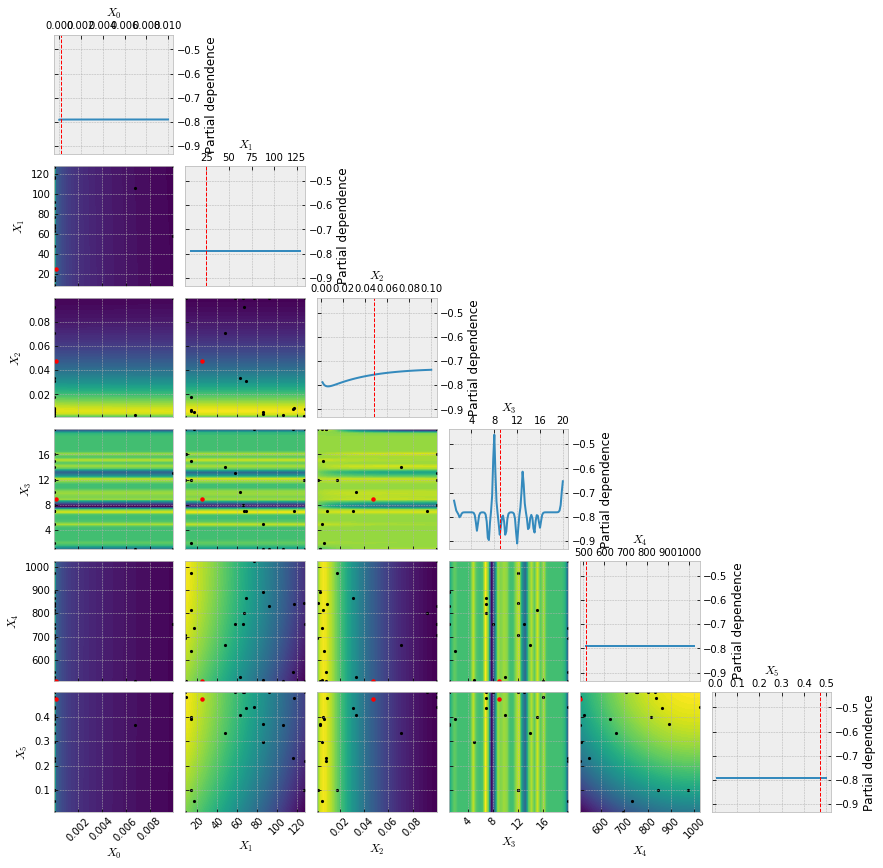

In [11]:
%matplotlib inline
from skopt.plots import plot_objective
plot_objective(result, levels=101, n_points=101);

In [12]:
plt.savefig('feta_mnist_loss.pdf')

In [17]:
opt.optimizer.Xi[np.argmin(opt.optimizer.yi)]

[0.00016148513983020747, 25, 0.047507314891545714, 9, 512, 0.47330947228248677]

In [18]:
from skopt.utils import expected_minimum
expected_minimum(result)

([0.00016148513983020747,
  25.0,
  0.047507314891545714,
  9.0,
  512.0,
  0.47330947228248677],
 -0.78140592575073242)

In [ ]:
{'n_hidden_set_units': 99, 'batch_size': 128, 'reg_strength': 1e-10, 'n_hidden_set_layers': 7, 'learning_rate': 0.028249056353850843, 'n_hidden_joint_layers': 3, 'n_hidden_joint_units': 128}

In [31]:
from keras.optimizers import SGD
from keras.metrics import binary_accuracy
from keras.regularizers import l2
from csrank.fate_choice import FATEChoiceFunction
n_hidden_set_units = 99
n_hidden_set_layers = 7
n_hidden_joint_units = 128
n_hidden_joint_layers = 3
fate = FATEChoiceFunction(n_object_features=n_features,
                          n_hidden_joint_layers=n_hidden_joint_layers,
                          n_hidden_joint_units=n_hidden_joint_units,
                          n_hidden_set_layers=n_hidden_set_layers,
                          n_hidden_set_units=n_hidden_set_units,
                          optimizer=SGD(lr=0.028249056353850843, momentum=0.9, nesterov=True),
                          #optimizer=opt,
                          batch_size=128,
                          kernel_regularizer=l2(1e-10))

2018-04-11 17:11:34,851 - FATERankingCore - INFO - Construct joint layers hidden units 128 and layers 3 
2018-04-11 17:11:34,853 - FATERankingCore - INFO - Construct output score node
2018-04-11 17:11:34,854 - FATEObjectRankingCore - INFO - args: {'batch_size': 128, 'optimizer': <keras.optimizers.SGD object at 0x7fcc1c11d940>, 'metrics': None, 'kernel_regularizer': <keras.regularizers.L1L2 object at 0x7fcc1c11db70>, 'n_hidden_joint_units': 128, 'n_hidden_joint_layers': 3}
2018-04-11 17:11:34,855 - FATEChoiceFunction - INFO - Creating set layers with set units 99 set layer 7 


In [32]:
from csrank.callbacks import LRScheduler
lr = LRScheduler(epochs_drop=epochs // 3, drop=0.1)

In [ ]:
fate.fit(X_train, Y_train, verbose=True, epochs=120, callbacks=[lr])

Train on 8100 samples, validate on 900 samples
Epoch 1/120


In [13]:
feta = opt.model

In [14]:
pred = feta.predict(X_test)
pred_scores = feta.predict_scores(X_test)

2018-04-12 21:23:21,046 - FETANetwork - INFO - Predicting scores
2018-04-12 21:23:21,095 - FETANetwork - INFO - For Test instances 10000 objects 10 features 128
2018-04-12 21:23:49,751 - FETANetwork - INFO - Done predicting scores
2018-04-12 21:23:49,752 - FETANetwork - INFO - Predicting scores
2018-04-12 21:23:49,801 - FETANetwork - INFO - For Test instances 10000 objects 10 features 128
2018-04-12 21:24:17,766 - FETANetwork - INFO - Done predicting scores


In [15]:
def instance_informedness(y_true, y_pred):
    tp = np.logical_and(y_true, y_pred).sum(axis=1)
    tn = np.logical_and(np.logical_not(y_true), np.logical_not(y_pred)).sum(axis=1)
    cp = y_true.sum(axis=1)
    cn = np.logical_not(y_true).sum(axis=1)
    return np.nanmean(tp/cp + tn/cn - 1)

In [16]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, hamming_loss, zero_one_loss, recall_score, roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import label_ranking_loss
f1 = f1_score(Y_test, pred, average='samples')
prec = precision_score(Y_test, pred, average='samples')
rec = recall_score(Y_test, pred, average='samples')
subsetloss = zero_one_loss(Y_test, pred)
hamming = hamming_loss(Y_test, pred)
informedness = instance_informedness(Y_test, pred)
#auc = roc_auc_score(Y_test, pred_scores, average='samples')
print('F1: {}\nPrecision: {}\nRecall: {}\nInformedness: {}\nSubset 0/1 Loss: {}\nHamming loss: {}'.format(
    f1, prec, rec, informedness, subsetloss, hamming))

F1: 0.9507278676878678
Precision: 0.9545757142857143
Recall: 0.9599926190476191
Informedness: 0.9506660331432765
Subset 0/1 Loss: 0.11380000000000001
Hamming loss: 0.01555


/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


0.94913124113565528